# Build a chatbot pipeline that generates responses based on user input without fine-tuning.

In [ ]:
!pip install -q "transformers==4.41.2"

In [ ]:
from transformers import pipeline

# At firsrt, check as a test:

In [ ]:
chatbot= pipeline("text2text-generation", model="facebook/blenderbot-400M-distill")

In [ ]:
chatbot.__dict__.keys()

dict_keys(['task', 'model', 'tokenizer', 'feature_extractor', 'image_processor', 'modelcard', 'framework', 'device', 'binary_output', 'call_count', '_batch_size', '_num_workers', '_preprocess_params', '_forward_params', '_postprocess_params'])

In [ ]:
patient_message="""
I have headache and pain in my stomach. give me advise what should i do? which doctor should see me?
"""

In [ ]:
print(chatbot(patient_message) )

[{'generated_text': ' I would go to the ER and get it checked out as soon as possible.'}]


In [ ]:
# it maked the response generate different each time:
response=chatbot(patient_message,max_new_tokens=50, do_sample=True, temperature=0.6,top_p=0.8 ,top_k=10)[0]["generated_text"]

In [ ]:
print(response)

 I would go to the ER and see if you have a headache or a sore throat.


# Now define as a function and apply KG:

In [ ]:
# Text2text chatbot
chatbot = pipeline("text2text-generation", model="facebook/blenderbot-400M-distill")

def generate_reply(msg, do_sample=True, temperature=0.6, top_p=0.8, top_k=10, max_new_tokens=200):
    out = chatbot(
        msg,
        do_sample=do_sample,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        max_new_tokens=max_new_tokens
    )[0]["generated_text"]
    return out

patient_message = "I have headache and pain in my stomach. What should I do? Which doctor should I see?"
print("Deterministic:\n", generate_reply(patient_message, do_sample=False))
print("\nSampled:\n", generate_reply(patient_message, do_sample=True))


/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:537: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `10` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Deterministic:
  I would go to the ER and get it checked out.  I hope you feel better soon!

Sampled:
  I would go to the ER and see if you have a sinus infection. 


In [ ]:
import pandas as pd

def generate_batch(messages, **gen_kwargs):
    return [generate_reply(m, **gen_kwargs) for m in messages]

messages = [
    "I have persistent cough and fever.",
    "My lower back hurts, especially in the morning.",
    "I feel chest tightness after climbing stairs."
]

batch_outputs = generate_batch(messages, do_sample=False)

# Build a DataFrame
df = pd.DataFrame({
    "user_message": messages,
    "bot_response": batch_outputs
})

print(df)

# optional: save to CSV
df.to_csv("chatbot_batch_results.csv", index=False)



                                      user_message  \
0               I have persistent cough and fever.   
1  My lower back hurts, especially in the morning.   
2    I feel chest tightness after climbing stairs.   

                                        bot_response  
0   Oh no!  I hope you feel better soon.  Are you...  
1   I'm sorry to hear that. Have you seen a docto...  
2   I'm sorry to hear that. Have you been doing i...  


## I recommend these two Youtube links and posts on Medium for undesrtanding knowledge graph:

### 1. https://www.youtube.com/watch?v=u7Z6osuKPqw&t=875s
### 2. https://www.youtube.com/watch?v=n7BTWc2C1Eg
### 3. https://www.youtube.com/watch?v=8eDWmLp_TKA&t=1808s
  
### 4. https://lopezyse.medium.com/make-interactive-knowledge-graphs-with-python-cfe520482197

### 5. https://lopezyse.medium.com/knowledge-graphs-from-scratch-with-python-f3c2a05914cc



In [ ]:
import networkx as nx
print(nx.__version__)


3.5


In [ ]:
import networkx as nx
import re

# --- A) Define specialties and a small symptom→specialty mapping (weights ~ typicality) ---
specialties = ["neurology", "gastroenterology", "cardiology", "pulmonology", "orthopedics", "general_practice"]

symptom_specialty = {
    "headache": {"neurology": 0.9, "general_practice": 0.6},
    "stomach pain": {"gastroenterology": 0.9, "general_practice": 0.6},
    "nausea": {"gastroenterology": 0.6, "general_practice": 0.5},
    "fever": {"general_practice": 0.8, "pulmonology": 0.5},
    "cough": {"pulmonology": 0.9, "general_practice": 0.6},
    "chest tightness": {"cardiology": 0.85, "pulmonology": 0.5},
    "shortness of breath": {"pulmonology": 0.85, "cardiology": 0.5},
    "lower back pain": {"orthopedics": 0.85, "general_practice": 0.6},
}

In [ ]:
G = nx.Graph()
for spec in specialties:
    G.add_node(spec, type="specialty")

In [ ]:
for sym, mp in symptom_specialty.items():
    G.add_node(sym, type="symptom")
    for spec, w in mp.items():
        G.add_edge(sym, spec, weight=w)

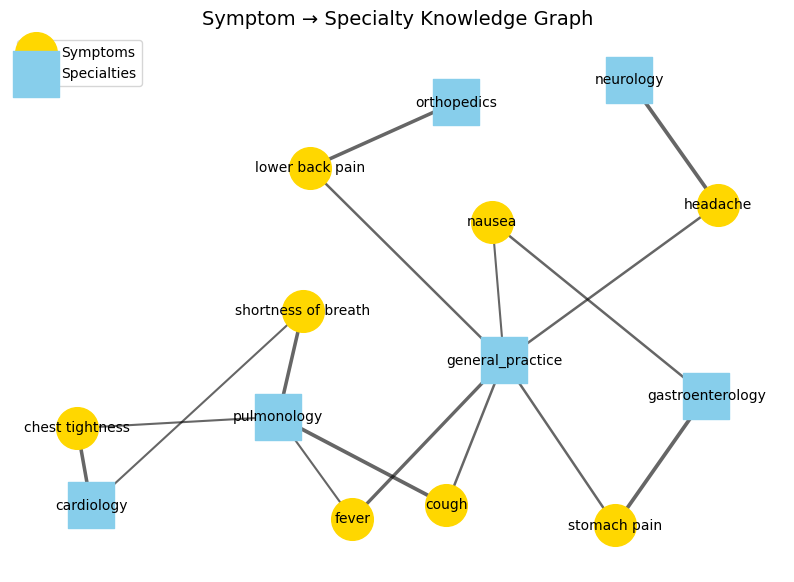

In [ ]:
import matplotlib.pyplot as plt


pos = nx.spring_layout(G, seed=42, k=0.8)


symptom_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "symptom"]
specialty_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "specialty"]

plt.figure(figsize=(10, 7))

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=symptom_nodes, node_color="gold", node_shape="o", node_size=900, label="Symptoms")
nx.draw_networkx_nodes(G, pos, nodelist=specialty_nodes, node_color="skyblue", node_shape="s", node_size=1100, label="Specialties")

# Draw edges with thickness ∝ weight
edges = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edges(G, pos, width=[3 * w for w in edges.values()], alpha=0.6)

# Labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.title("Symptom → Specialty Knowledge Graph", fontsize=14)
plt.legend(scatterpoints=1)
plt.axis("off")
plt.show()


### Text Processing using Regex:
### https://medium.com/%40monicanogueras/15-examples-for-advanced-text-processing-using-regex-48223adc720d

In [ ]:
import re

def extract_symptoms_from_text(text):
    """Find known symptoms or synonyms in the text and return canonical names."""
    matches = []
    for sym in symptom_specialty:
        if sym in text:
            matches.append(sym)
    return list(matches)


def score_specialties(symptoms):
    """Add up specialty scores for each symptom and return top list."""
    scores = {}

    for sym in symptoms:
        if sym in symptom_specialty:
            for spec, w in symptom_specialty[sym].items():
                # add weight to this specialty
                scores[spec] = scores.get(spec, 0) + w
        else:
            # fallback for unknown symptom
            scores["general_practice"] = scores.get("general_practice", 0) + 0.2

    # sort by score, highest first
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return ranked, scores

def explain_recommendation(symptoms, ranked, scores):
    """Make a short explanation string."""
    if not symptoms:
        return "No symptoms recognized; recommend general practice."
    top_spec, top_score = ranked[0]
    return f"Symptoms {symptoms} → best specialty: {top_spec} (score={top_score:.2f})"


In [ ]:
df["extracted_symptoms"] = df["user_message"].apply(extract_symptoms_from_text)

df["specialty_scores"] = df["extracted_symptoms"].apply(lambda syms: score_specialties(syms)[1])
df["top_specialty"] = df["extracted_symptoms"].apply(lambda syms: score_specialties(syms)[0][0][0] if syms else "general_practice")
df["kg_explanation"] = df.apply(
    lambda row: explain_recommendation(row["extracted_symptoms"], *score_specialties(row["extracted_symptoms"])),
    axis=1
)

df


,user_message,bot_response,extracted_symptoms,specialty_scores,top_specialty,kg_explanation
0,I have persistent cough and fever.,Oh no! I hope you feel better soon. Are you...,"[fever, cough]","{'general_practice': 1.4, 'pulmonology': 1.4}",general_practice,"Symptoms ['fever', 'cough'] → best specialty: ..."
1,"My lower back hurts, especially in the morning.",I'm sorry to hear that. Have you seen a docto...,[],{},general_practice,No symptoms recognized; recommend general prac...
2,I feel chest tightness after climbing stairs.,I'm sorry to hear that. Have you been doing i...,[chest tightness],"{'cardiology': 0.85, 'pulmonology': 0.5}",cardiology,Symptoms ['chest tightness'] → best specialty:...
